# Importing libraries

In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, TimeDistributed, Bidirectional, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Reading data

In [2]:
# Loading the data without headers
data_train_X = pd.read_csv("readable_datasets/amino_acids_train.txt", header=None)
data_train_y = pd.read_csv("readable_datasets/pss_train.txt", header=None)
data_test_X = pd.read_csv("readable_datasets/amino_acids_test.txt", header=None)
data_test_y = pd.read_csv("readable_datasets/pss_test.txt", header=None)

In [3]:
# Printing the first few rows
print(data_train_X.head())

                                                   0
0  F D Y Q T V Y F A N Q Y G L R T I E L G E S E ...
1  R P E S E L I R Q S W R V V S R S P L E H G T ...
2  M K I A I L G A G C Y R T H A A A G I T N F M ...
3  R R T V P R G T L R K I I K K H K P H L R L A ...
4  Q V E I S X A E W D V X N I I W D K K S V S A ...


# Data preprocessing

In [4]:
# Tokenizing the amino acids for embedding extraction
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(data_train_X[0].tolist())
vocab_size = len(tokenizer.word_index) + 1

In [5]:
# Convert sequences to integer tokens
X_train_glove = tokenizer.texts_to_sequences(data_train_X[0].tolist())
X_test_glove = tokenizer.texts_to_sequences(data_test_X[0].tolist())

In [6]:
# Padding the sequences for uniform length
max_seq_len = 700
X_train_padded = pad_sequences(X_train_glove, maxlen=max_seq_len, padding="post")
X_test_padded = pad_sequences(X_test_glove, maxlen=max_seq_len, padding="post")

In [7]:
# defining function to remove the white space
def preprocess_labels(data_y):
   
    processed_data_y = [str(seq).replace(" ", "") for seq in data_y[0].tolist()]
    return processed_data_y

In [8]:
# Removing the white spaces
pss_train = preprocess_labels(data_train_y)
pss_test = preprocess_labels(data_test_y)

In [9]:
# Printing  unique labels before encoding
unique_labels_train = set("".join(pss_train))
unique_labels_test = set("".join(pss_test))
print("Unique labels in training data (before encoding):", unique_labels_train)
print("Unique labels in test data (before encoding):", unique_labels_test)

Unique labels in training data (before encoding): {'L', 'S', 'B', 'H', 'G', 'T', 'E', 'I'}
Unique labels in test data (before encoding): {'L', 'S', 'B', 'H', 'G', 'T', 'E', 'I'}


In [10]:
#label encoding the target labels with LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(list(unique_labels_train | unique_labels_test))  # Fit on all unique labels across train and test

LabelEncoder()

In [11]:
# encoding and padding the encoded labels
y_train_encoded = [label_encoder.transform(list(seq)) for seq in pss_train]
y_test_encoded = [label_encoder.transform(list(seq)) for seq in pss_test]
y_train_padded = pad_sequences(y_train_encoded, maxlen=max_seq_len, padding="post")
y_test_padded = pad_sequences(y_test_encoded, maxlen=max_seq_len, padding="post")

In [12]:
# Converting the encoded labels to one-hot encoding labels
y_train_categorical = to_categorical(y_train_padded, num_classes=len(label_encoder.classes_))
y_test_categorical = to_categorical(y_test_padded, num_classes=len(label_encoder.classes_))

In [13]:
# Printing the  unique labels after encoding
print("Unique encoded labels in training data:", np.unique(y_train_padded))
print("Unique encoded labels in test data:", np.unique(y_test_padded))

Unique encoded labels in training data: [0 1 2 3 4 5 6 7]
Unique encoded labels in test data: [0 1 2 3 4 5 6 7]


In [14]:
# Loading the GloVe embeddings
embedding_dim = 100
glove_embeddings = {}
with open("glove.6B.100d.txt", "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        glove_embeddings[word] = vector

In [15]:
# Creating an embedding matrix for the amino acid sequences
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Model training

In [21]:
# Building the LSTM model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], 
              input_length=max_seq_len, trainable=False),
    LSTM(64, return_sequences=True),
    TimeDistributed(Dense(32, activation="relu")),
    TimeDistributed(Dense(len(label_encoder.classes_), activation="softmax"))
])

In [22]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [23]:
# Training the model
model2 = model.fit(X_train_padded, y_train_categorical, 
                    validation_data=(X_test_padded, y_test_categorical), 
                    epochs=10, batch_size=32)

Epoch 1/10
173/173 [==============================] - 38s 207ms/step - loss: 1.0075 - accuracy: 0.6962 - val_loss: 0.6778 - val_accuracy: 0.7739
Epoch 2/10
173/173 [==============================] - 39s 223ms/step - loss: 0.8656 - accuracy: 0.7065 - val_loss: 0.6903 - val_accuracy: 0.7705
Epoch 3/10
173/173 [==============================] - 39s 223ms/step - loss: 0.8679 - accuracy: 0.7030 - val_loss: 0.6846 - val_accuracy: 0.7745
Epoch 4/10
173/173 [==============================] - 41s 234ms/step - loss: 0.8227 - accuracy: 0.7194 - val_loss: 0.5981 - val_accuracy: 0.7911
Epoch 5/10
173/173 [==============================] - 39s 227ms/step - loss: 0.7502 - accuracy: 0.7404 - val_loss: 0.5951 - val_accuracy: 0.7904
Epoch 6/10
173/173 [==============================] - 38s 221ms/step - loss: 0.7426 - accuracy: 0.7414 - val_loss: 0.5910 - val_accuracy: 0.7931
Epoch 7/10
173/173 [==============================] - 39s 227ms/step - loss: 0.7353 - accuracy: 0.7429 - val_loss: 0.6554 - val_ac

In [24]:
# Evaluate the model
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=-1)
y_test_classes = np.argmax(y_test_categorical, axis=-1)

17/17 [==============================] - 1s 63ms/step


In [28]:
# Calculating the accuracy for test set
test_accuracy = accuracy_score(y_test_classes.flatten(), y_pred_classes.flatten())
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.7710644802668148


In [25]:
# Flattening predictions
y_pred_flat = y_pred_classes.flatten()
y_test_flat = y_test_classes.flatten()
print(classification_report(y_test_flat, y_pred_flat, target_names=label_encoder.classes_))

C:\Users\anjal\anaconda3\New folder\envs\renv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\anjal\anaconda3\New folder\envs\renv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           B       0.95      0.92      0.94    276216
           E       0.33      0.00      0.00     18016
           G       0.00      0.00      0.00      3132
           H       0.24      0.83      0.37     26157
           I       0.00      0.00      0.00        30
           L       0.62      0.05      0.10     17920
           S       0.00      0.00      0.00      8316
           T       0.00      0.00      0.00     10013

    accuracy                           0.77    359800
   macro avg       0.27      0.23      0.18    359800
weighted avg       0.80      0.77      0.75    359800



C:\Users\anjal\anaconda3\New folder\envs\renv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


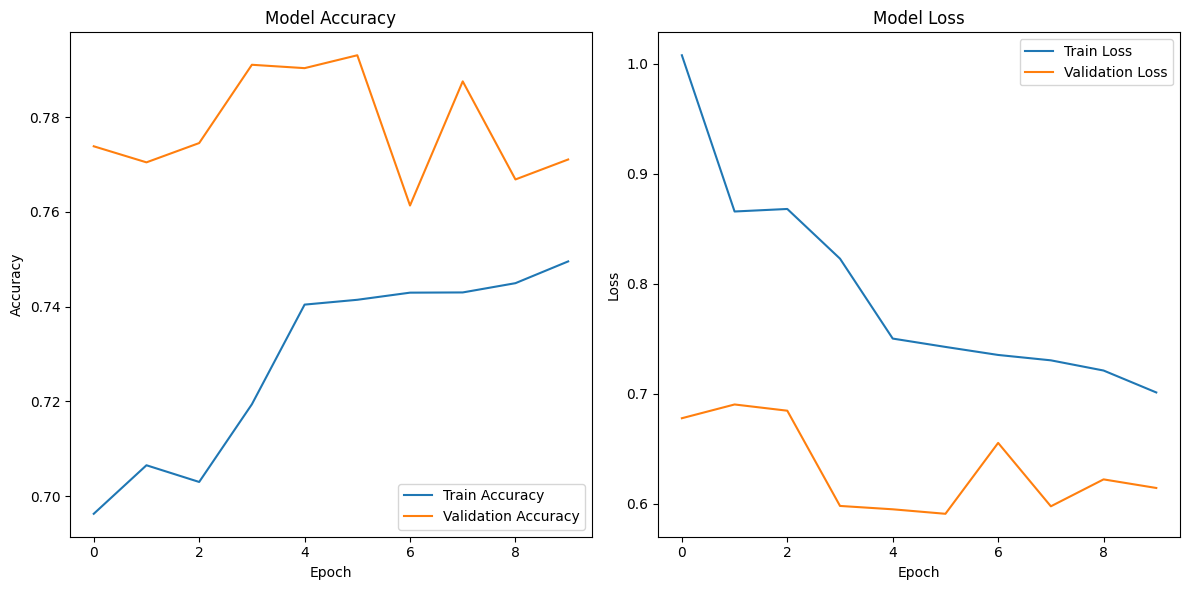

In [30]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model2.history['accuracy'], label='Train Accuracy')
plt.plot(model2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model2.history['loss'], label='Train Loss')
plt.plot(model2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

# Hyperparametric Tuning

In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
# Defining input shape and dimension
input_shape = (max_seq_len, embedding_dim)
num_classes = len(label_encoder.classes_)

In [20]:
# Building the enhanced model
model2 = Sequential([
    # Embedding layer
    tf.keras.layers.Embedding(input_dim=vocab_size, 
                              output_dim=embedding_dim, 
                              weights=[embedding_matrix], 
                              input_length=max_seq_len, 
                              trainable=False),
    
    # BiLSTM layer with 128 units
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),  
    
    # Adding Another Bilstm layer for increasing learning
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    
    # Dense layers to reduce dimensionality
    TimeDistributed(Dense(64, activation='relu')),
    TimeDistributed(Dense(32, activation='relu')),  
    
    # Output layer with softmax activation for multi-class classification
    TimeDistributed(Dense(num_classes, activation='softmax'))
])

In [21]:
# Compiling the mode
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
#Early stopping 
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [25]:
# Training the model
training2 = model2.fit(
    X_train_padded, y_train_categorical,
    validation_data=(X_test_padded, y_test_categorical),
    epochs=20,  # tuning for 20 epocs
    batch_size=32,  
    callbacks=[early_stopping]
)

Epoch 1/20
173/173 [==============================] - 260s 1s/step - loss: 0.8585 - accuracy: 0.6997 - val_loss: 0.5618 - val_accuracy: 0.8167
Epoch 2/20
173/173 [==============================] - 291s 2s/step - loss: 0.6270 - accuracy: 0.7685 - val_loss: 0.4370 - val_accuracy: 0.8298
Epoch 3/20
173/173 [==============================] - 323s 2s/step - loss: 0.5577 - accuracy: 0.7895 - val_loss: 0.4255 - val_accuracy: 0.8338
Epoch 4/20
173/173 [==============================] - 325s 2s/step - loss: 0.5470 - accuracy: 0.7929 - val_loss: 0.4303 - val_accuracy: 0.8316
Epoch 5/20
173/173 [==============================] - 314s 2s/step - loss: 0.5406 - accuracy: 0.7942 - val_loss: 0.4162 - val_accuracy: 0.8362
Epoch 6/20
173/173 [==============================] - 333s 2s/step - loss: 0.5402 - accuracy: 0.7943 - val_loss: 0.4242 - val_accuracy: 0.8332
Epoch 7/20
173/173 [==============================] - 310s 2s/step - loss: 0.5394 - accuracy: 0.7944 - val_loss: 0.4344 - val_accuracy: 0.8302

In [26]:
# Evaluating the model
loss2, accuracy2 = model2.evaluate(X_test_padded, y_test_categorical, verbose=0)
print(f"Test Accuracy2: {accuracy2 * 100:.2f}%")

Test Accuracy2: 83.62%


In [27]:

y_pred2 = model2.predict(X_test_padded)
y_pred_labels2 = np.argmax(y_pred2, axis=-1).flatten()
y_test_labels = np.argmax(y_test_categorical, axis=-1).flatten()

17/17 [==============================] - 34s 2s/step


In [28]:
# Classification report
print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels2, target_names=label_encoder.classes_))

Classification Report:


C:\Users\anjal\anaconda3\New folder\envs\renv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           B       0.99      0.99      0.99    276216
           E       0.00      0.00      0.00     18016
           G       0.00      0.00      0.00      3132
           H       0.31      0.96      0.47     26157
           I       0.00      0.00      0.00        30
           L       0.55      0.06      0.11     17920
           S       0.00      0.00      0.00      8316
           T       0.00      0.00      0.00     10013

    accuracy                           0.84    359800
   macro avg       0.23      0.25      0.20    359800
weighted avg       0.81      0.84      0.80    359800



C:\Users\anjal\anaconda3\New folder\envs\renv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\anjal\anaconda3\New folder\envs\renv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


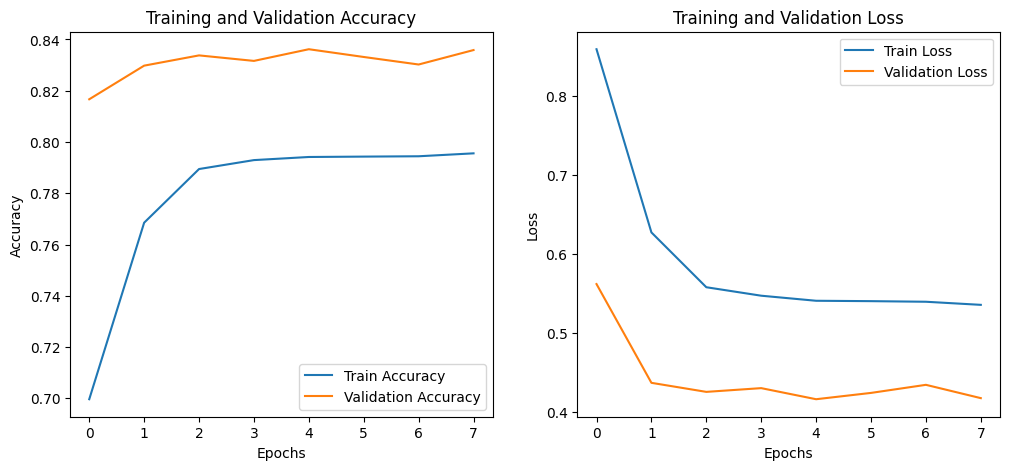

In [29]:
# Plotting accuracy and loss
plt.figure(figsize=(12, 5))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(training2.history['accuracy'], label='Train Accuracy')
plt.plot(training2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(training2.history['loss'], label='Train Loss')
plt.plot(training2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()